In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pathlib import Path
import re
import warnings

warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Paths
DATA_DIR = Path('../data/processed')
PLOTS_DIR = Path('../plots/eda')
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Plots directory: {PLOTS_DIR}")

Data directory: ../data/processed
Plots directory: ../plots/eda


## 1. Load and Inspect Data

In [2]:
# Load datasets
train_df = pd.read_csv(DATA_DIR / 'train.csv')
val_df = pd.read_csv(DATA_DIR / 'val.csv')
test_df = pd.read_csv(DATA_DIR / 'test.csv')

print(f"Train samples: {len(train_df):,}")
print(f"Validation samples: {len(val_df):,}")
print(f"Test samples: {len(test_df):,}")
print(f"Total samples: {len(train_df) + len(val_df) + len(test_df):,}")

Train samples: 15,249
Validation samples: 2,692
Test samples: 11,005
Total samples: 28,946


In [3]:
# Inspect data structure
print("Train DataFrame Info:")
print(train_df.info())
print("\nFirst 5 samples:")
train_df.head()

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15249 entries, 0 to 15248
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   15249 non-null  int64 
 1   text    15003 non-null  object
 2   label   15249 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 357.5+ KB
None

First 5 samples:


,index,text,label
0,3365,micul oras californian diablo este afectat de ...,0
1,8239,asta e corect. filmul este mai bun decat carte...,1
2,4410,"un alt ""fiu care nu va creste"" si doar celelal...",0
3,4552,boxa ideala\nsuper ok.,1
4,621,"eu cred ca in cinematografie, scopul principal...",1


In [5]:
# Check for missing values
print("Missing values:")
print(f"  Train: {train_df.isnull().sum().sum()}")
print(f"  Val: {val_df.isnull().sum().sum()}")
print(f"  Test: {test_df.isnull().sum().sum()}")

# Drop rows with missing text
train_df = train_df.dropna(subset=['text'])
val_df = val_df.dropna(subset=['text'])
test_df = test_df.dropna(subset=['text'])

Missing values:
  Train: 246
  Val: 44
  Test: 0


In [7]:
# Sample texts from each class
label_names = {0: 'Negative', 1: 'Positive'}

print("Sample NEGATIVE reviews:")
print("-" * 50)
for text in train_df[train_df['label'] == 0]['text'].sample(3, random_state=42).values:
    print(f"• {text[:200]}...\n")

print("\nSample POSITIVE reviews:")
print("-" * 50)
for text in train_df[train_df['label'] == 1]['text'].sample(3, random_state=42).values:
    print(f"• {text[:200]}...\n")

Sample NEGATIVE reviews:
--------------------------------------------------
• m-am gandit la harvey keitel, un tanar proaspat de la sex pistols john lydon, apoi ca bonus, muzica lui ennio morricone. m-am asteptat la un thriller de politie al scolii de varsta frageda, care a fos...

• bine, al gore! ati devenit prima persoana care a facut 1 miliard de dolari din minciuna impotriva incalzirii globale! la fel ca celalalt om care a facut fabula in lume, acesta este acolo cu cele mai b...

• trebuia sa revizuiesc acest lucru pentru un site web si m-am uitat cu optimism ca poate ar fi cel putin o ruptura ciudata si inca distractiva si nici macar nu a facut asta destul de bine. 666: copilul...


Sample POSITIVE reviews:
--------------------------------------------------
• just cause este un film eronat, dar decent, care este sustinut de performante puternice si de o scriere creativa (desi extrem de previzibila). sean connery este un cruciad pentru pedeapsa cu moartea a...

• excelent
parfum o

## 2. Class Balance Analysis

In [8]:
# Class distribution for each split
def get_class_distribution(df, name):
    counts = df['label'].value_counts().sort_index()
    total = len(df)
    return {
        'split': name,
        'negative': counts.get(0, 0),
        'positive': counts.get(1, 0),
        'neg_pct': counts.get(0, 0) / total * 100,
        'pos_pct': counts.get(1, 0) / total * 100,
        'total': total
    }

dist_train = get_class_distribution(train_df, 'Train')
dist_val = get_class_distribution(val_df, 'Validation')
dist_test = get_class_distribution(test_df, 'Test')

dist_df = pd.DataFrame([dist_train, dist_val, dist_test])
print("Class Distribution Summary:")
dist_df

Class Distribution Summary:


,split,negative,positive,neg_pct,pos_pct,total
0,Train,5806,9197,38.698927,61.301073,15003
1,Validation,1020,1628,38.519637,61.480363,2648
2,Test,4828,6177,43.870968,56.129032,11005


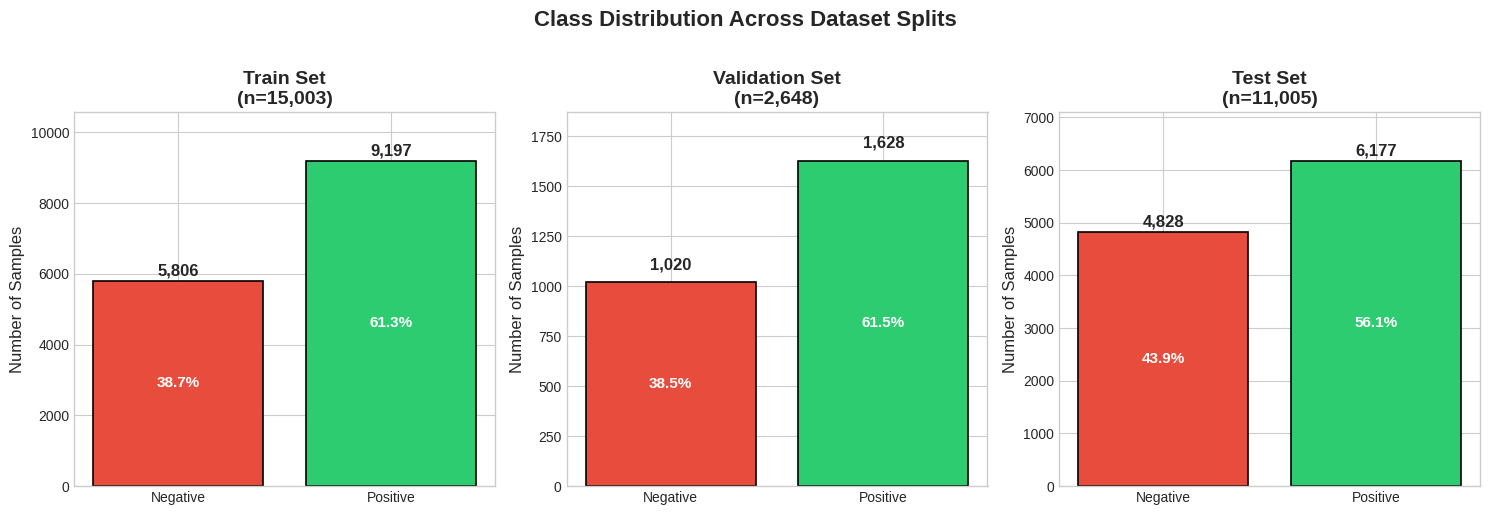


✓ Plot saved to ../plots/eda/class_balance.png


In [9]:
# Visualize class balance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

datasets = [('Train', train_df), ('Validation', val_df), ('Test', test_df)]
colors = ['#e74c3c', '#2ecc71']  # Red for negative, green for positive

for ax, (name, df) in zip(axes, datasets):
    counts = df['label'].value_counts().sort_index()
    bars = ax.bar(['Negative', 'Positive'], counts.values, color=colors, edgecolor='black', linewidth=1.2)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
                f'{count:,}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    # Add percentage labels
    total = len(df)
    for bar, count in zip(bars, counts.values):
        pct = count / total * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                f'{pct:.1f}%', ha='center', va='center', fontsize=11, color='white', fontweight='bold')
    
    ax.set_title(f'{name} Set\n(n={total:,})', fontsize=14, fontweight='bold')
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.set_ylim(0, max(counts.values) * 1.15)

plt.suptitle('Class Distribution Across Dataset Splits', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'class_balance.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {PLOTS_DIR / 'class_balance.png'}")

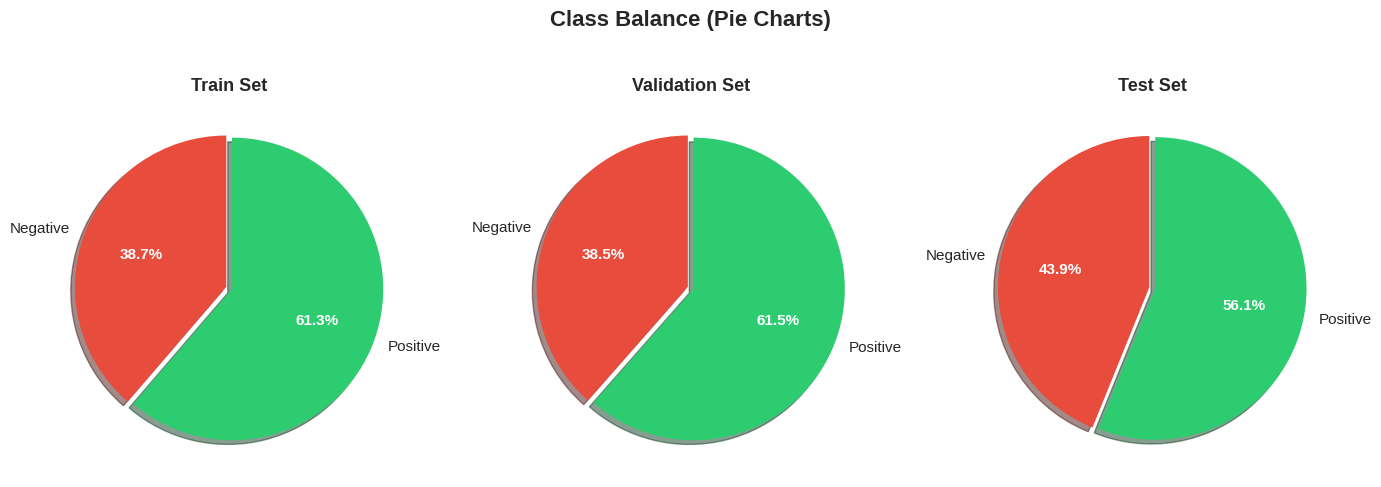

In [10]:
# Combined pie chart
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

for ax, (name, df) in zip(axes, datasets):
    counts = df['label'].value_counts().sort_index()
    wedges, texts, autotexts = ax.pie(
        counts.values, 
        labels=['Negative', 'Positive'],
        colors=colors,
        autopct='%1.1f%%',
        startangle=90,
        explode=(0.02, 0.02),
        shadow=True,
        textprops={'fontsize': 11}
    )
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
    ax.set_title(f'{name} Set', fontsize=13, fontweight='bold')

plt.suptitle('Class Balance (Pie Charts)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(PLOTS_DIR / 'class_balance_pie.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Text Length Distribution

In [11]:
# Calculate text lengths
def add_length_features(df):
    df = df.copy()
    df['char_count'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    df['avg_word_len'] = df['char_count'] / df['word_count']
    return df

train_df = add_length_features(train_df)
val_df = add_length_features(val_df)
test_df = add_length_features(test_df)

# Summary statistics
print("Text Length Statistics (Training Set):")
print("=" * 50)
print(train_df[['char_count', 'word_count', 'avg_word_len']].describe().round(2))

Text Length Statistics (Training Set):
       char_count  word_count  avg_word_len
count    15003.00    15003.00      15003.00
mean       444.44       77.71          5.91
std        291.12       50.93          2.45
min          5.00        1.00          2.50
25%        147.00       26.00          5.42
50%        447.00       79.00          5.73
75%        718.00      126.00          6.07
max       1977.00      373.00        141.50


In [12]:
# Length statistics by class
print("\nText Length by Sentiment Class:")
print("=" * 50)
length_by_class = train_df.groupby('label')[['word_count', 'char_count']].agg(['mean', 'median', 'std', 'min', 'max'])
length_by_class.index = ['Negative', 'Positive']
length_by_class.round(2)


Text Length by Sentiment Class:


word_count                        char_count                         
               mean median    std min  max       mean median     std min   max
Negative      95.92  111.0  45.73   1  373     543.28  630.0  260.96   6  1977
Positive      66.21   56.0  50.69   1  192     382.05  317.0  291.90   5  1090

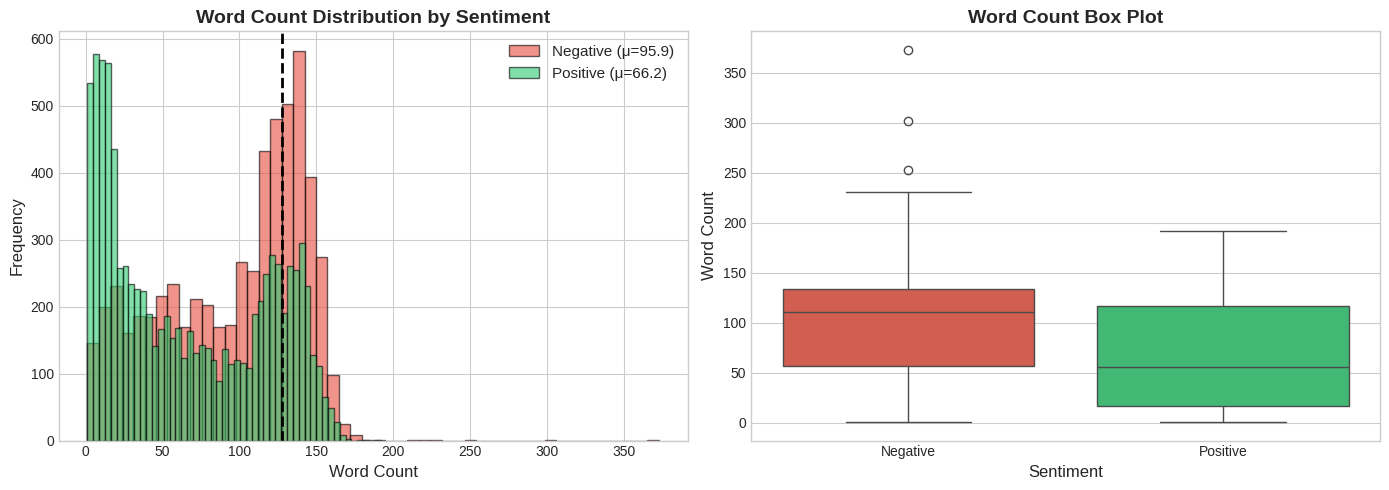


✓ Plot saved to ../plots/eda/word_count_distribution.png


In [ ]:
# Word count distribution by class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
for label, color, name in [(0, '#e74c3c', 'Negative'), (1, '#2ecc71', 'Positive')]:
    data = train_df[train_df['label'] == label]['word_count']
    ax.hist(data, bins=50, alpha=0.6, label=f'{name} (μ={data.mean():.1f})', color=color, edgecolor='black')

ax.set_xlabel('Word Count', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Word Count Distribution by Sentiment', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.axvline(160, color='black', linestyle='--', linewidth=2, label='max_seq_len=160')

# Box plot
ax = axes[1]
train_df['sentiment'] = train_df['label'].map({0: 'Negative', 1: 'Positive'})
sns.boxplot(data=train_df, x='sentiment', y='word_count', palette=['#e74c3c', '#2ecc71'], ax=ax)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Word Count', fontsize=12)
ax.set_title('Word Count Box Plot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'word_count_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {PLOTS_DIR / 'word_count_distribution.png'}")

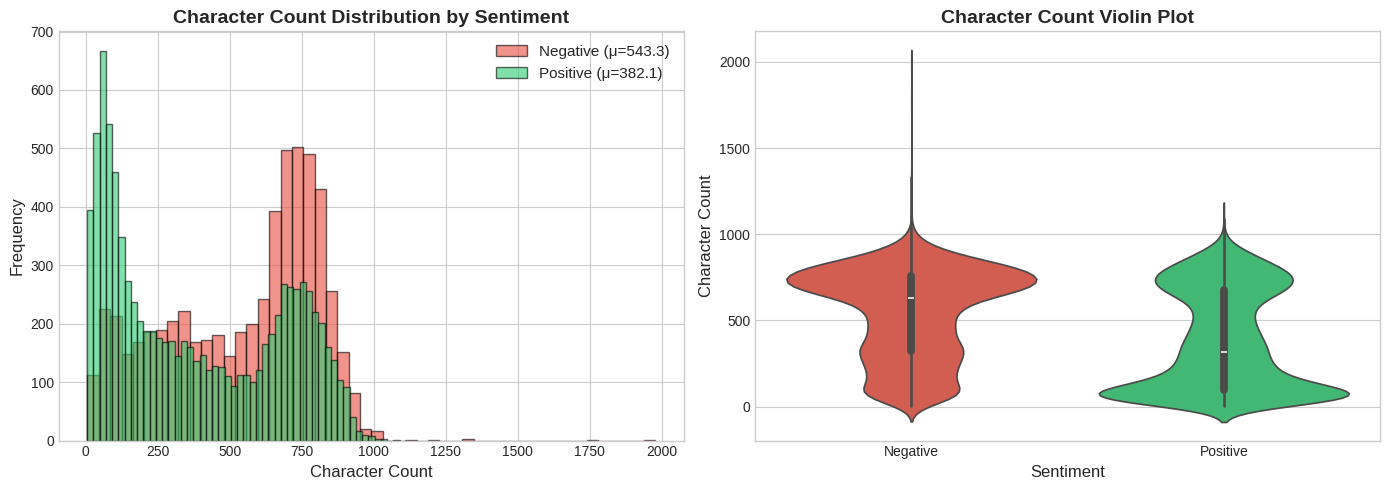

In [14]:
# Character count distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax = axes[0]
for label, color, name in [(0, '#e74c3c', 'Negative'), (1, '#2ecc71', 'Positive')]:
    data = train_df[train_df['label'] == label]['char_count']
    ax.hist(data, bins=50, alpha=0.6, label=f'{name} (μ={data.mean():.1f})', color=color, edgecolor='black')

ax.set_xlabel('Character Count', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Character Count Distribution by Sentiment', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)

# Violin plot
ax = axes[1]
sns.violinplot(data=train_df, x='sentiment', y='char_count', palette=['#e74c3c', '#2ecc71'], ax=ax)
ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Character Count', fontsize=12)
ax.set_title('Character Count Violin Plot', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'char_count_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Sequence length analysis for padding decision
percentiles = [50, 75, 90, 95, 99]
print("Word Count Percentiles (for max_seq_len decision):")
print("=" * 50)
for p in percentiles:
    val = np.percentile(train_df['word_count'], p)
    coverage = (train_df['word_count'] <= val).mean() * 100
    print(f"  {p}th percentile: {val:.0f} words ({coverage:.1f}% of samples)")

# Recommendation
p95 = np.percentile(train_df['word_count'], 95)
print(f"\n→ Recommended max_seq_len: {int(np.ceil(p95 / 32) * 32)} (covers 95% of samples)")

Word Count Percentiles (for max_seq_len decision):
  50th percentile: 79 words (50.4% of samples)
  75th percentile: 126 words (75.5% of samples)
  90th percentile: 142 words (90.5% of samples)
  95th percentile: 148 words (95.0% of samples)
  99th percentile: 160 words (99.1% of samples)

→ Recommended max_seq_len: 160 (covers 95% of samples)


## 4. Most Frequent Words Analysis

In [ ]:
# Simple tokenizer for word frequency analysis
def simple_tokenize(text):
    """Basic tokenization: lowercase, keep Romanian chars, split on whitespace."""
    text = text.lower()
    text = re.sub(r'[^a-zăâîșț\s]', ' ', text)
    return text.split()

# Get word frequencies by class
def get_word_freq(df, label):
    texts = df[df['label'] == label]['text']
    words = []
    for text in texts:
        words.extend(simple_tokenize(text))
    return Counter(words)

neg_freq = get_word_freq(train_df, 0)
pos_freq = get_word_freq(train_df, 1)

print(f"Unique words in NEGATIVE reviews: {len(neg_freq):,}")
print(f"Unique words in POSITIVE reviews: {len(pos_freq):,}")

Unique words in NEGATIVE reviews: 32,606
Unique words in POSITIVE reviews: 33,195


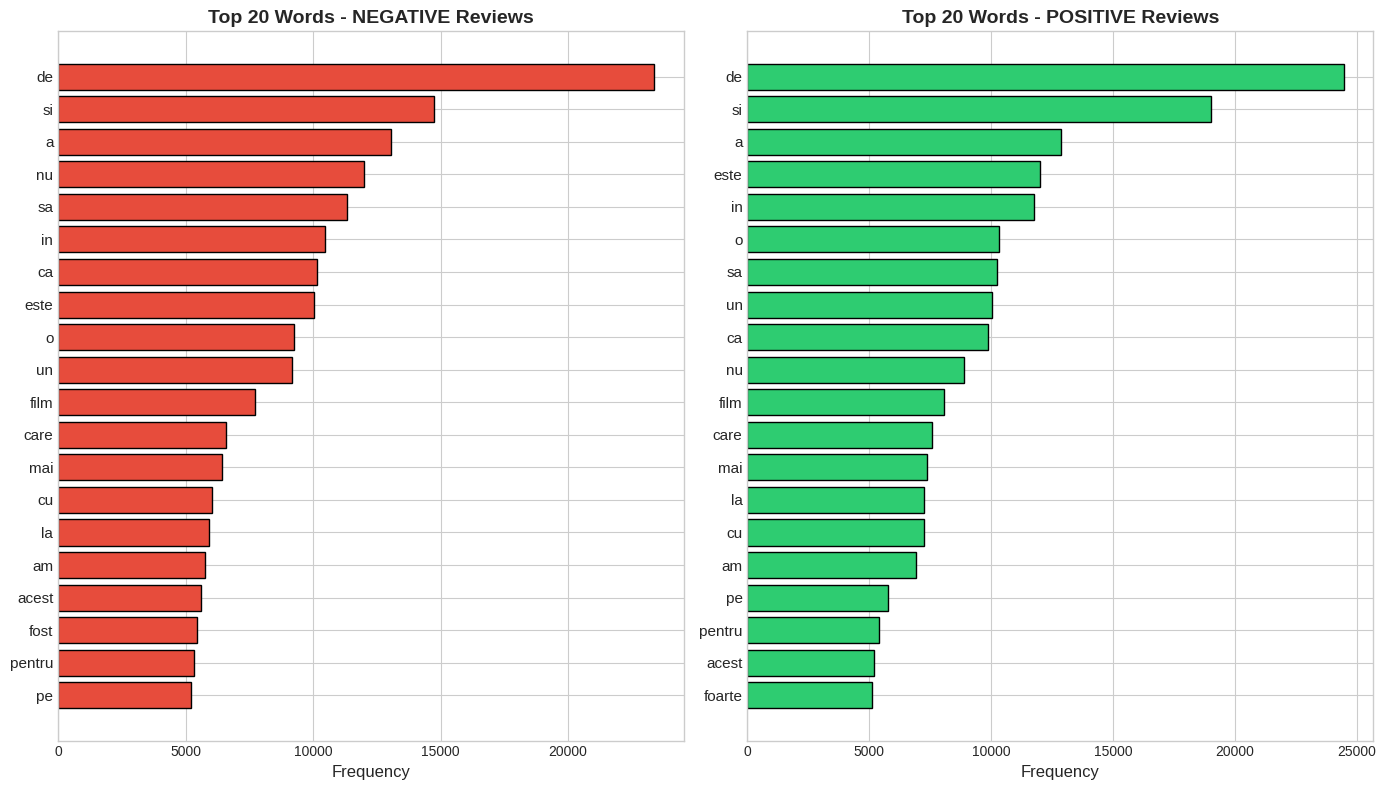


✓ Plot saved to ../plots/eda/top_words_by_class.png


In [18]:
# Top 20 most common words per class
n_top = 20

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Negative class
ax = axes[0]
top_neg = neg_freq.most_common(n_top)
words, counts = zip(*top_neg)
y_pos = range(len(words))
ax.barh(y_pos, counts, color='#e74c3c', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(words, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title(f'Top {n_top} Words - NEGATIVE Reviews', fontsize=14, fontweight='bold')

# Positive class
ax = axes[1]
top_pos = pos_freq.most_common(n_top)
words, counts = zip(*top_pos)
y_pos = range(len(words))
ax.barh(y_pos, counts, color='#2ecc71', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(words, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title(f'Top {n_top} Words - POSITIVE Reviews', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'top_words_by_class.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {PLOTS_DIR / 'top_words_by_class.png'}")

In [19]:
# Load Romanian stopwords for filtering
import spacy
nlp = spacy.load('ro_core_news_sm')
romanian_stopwords = nlp.Defaults.stop_words
print(f"Loaded {len(romanian_stopwords)} Romanian stopwords from spaCy")


Loaded 494 Romanian stopwords from spaCy


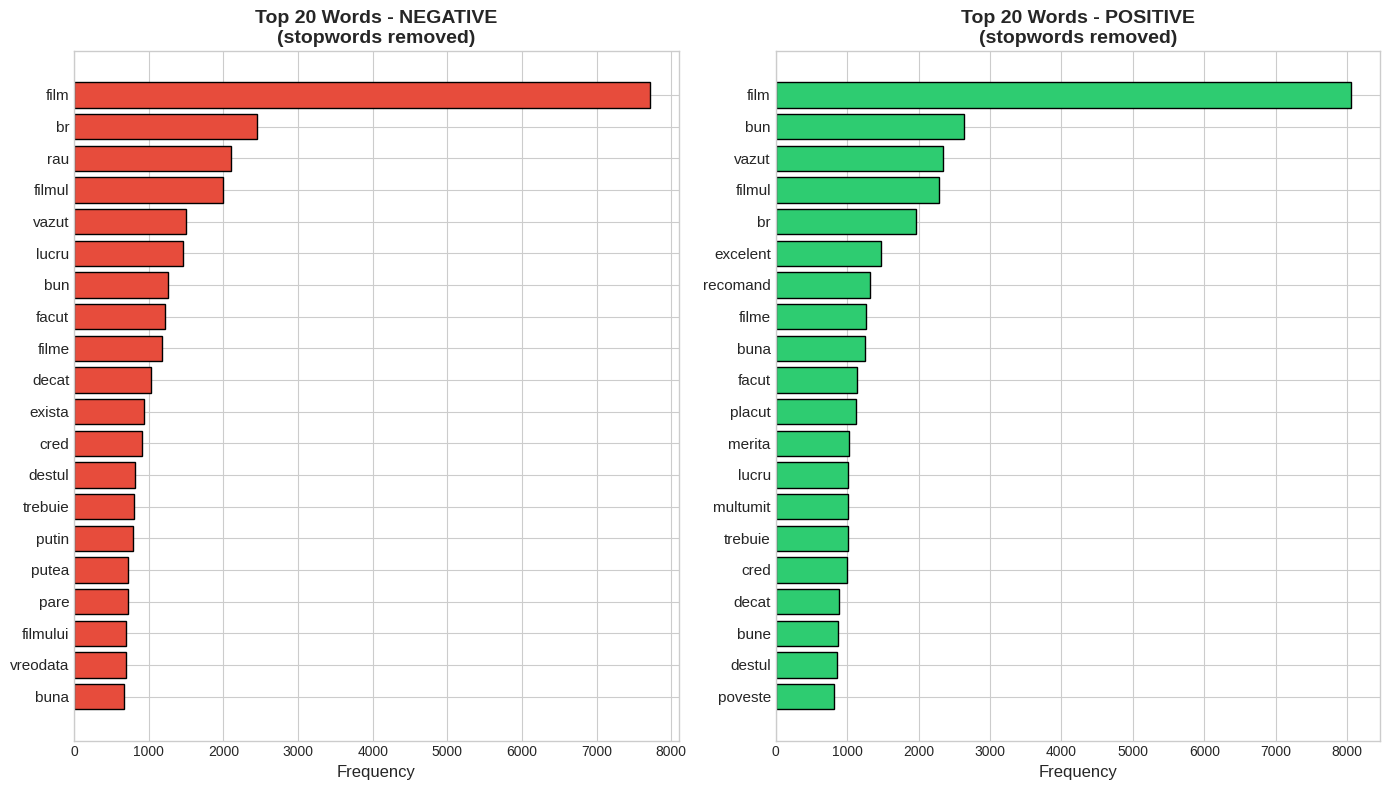


✓ Plot saved to ../plots/eda/top_words_filtered.png


In [20]:
# Top words WITHOUT stopwords
def filter_stopwords(freq_counter, stopwords, min_len=2):
    """Remove stopwords and short words."""
    return Counter({
        word: count for word, count in freq_counter.items() 
        if word not in stopwords and len(word) >= min_len
    })

neg_freq_filtered = filter_stopwords(neg_freq, romanian_stopwords)
pos_freq_filtered = filter_stopwords(pos_freq, romanian_stopwords)

# Plot filtered words
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Negative class (filtered)
ax = axes[0]
top_neg = neg_freq_filtered.most_common(n_top)
words, counts = zip(*top_neg)
y_pos = range(len(words))
ax.barh(y_pos, counts, color='#e74c3c', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(words, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title(f'Top {n_top} Words - NEGATIVE\n(stopwords removed)', fontsize=14, fontweight='bold')

# Positive class (filtered)
ax = axes[1]
top_pos = pos_freq_filtered.most_common(n_top)
words, counts = zip(*top_pos)
y_pos = range(len(words))
ax.barh(y_pos, counts, color='#2ecc71', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(words, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Frequency', fontsize=12)
ax.set_title(f'Top {n_top} Words - POSITIVE\n(stopwords removed)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'top_words_filtered.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {PLOTS_DIR / 'top_words_filtered.png'}")

In [21]:
# Class-distinctive words (high in one class, low in other)
def get_distinctive_words(freq1, freq2, top_n=20):
    """Find words that are distinctive for freq1 vs freq2."""
    total1 = sum(freq1.values())
    total2 = sum(freq2.values())
    
    # Calculate relative frequency ratio
    ratios = {}
    for word in freq1:
        if freq1[word] >= 50:  # Minimum frequency threshold
            rel1 = freq1[word] / total1
            rel2 = freq2.get(word, 1) / total2
            ratios[word] = rel1 / rel2
    
    return sorted(ratios.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Distinctive negative words
neg_distinctive = get_distinctive_words(neg_freq_filtered, pos_freq_filtered)
# Distinctive positive words  
pos_distinctive = get_distinctive_words(pos_freq_filtered, neg_freq_filtered)

print("Most DISTINCTIVE words for each class:")
print("=" * 50)
print("\nNEGATIVE-distinctive words:")
for word, ratio in neg_distinctive[:10]:
    print(f"  {word}: {ratio:.2f}x more common in negative")

print("\nPOSITIVE-distinctive words:")
for word, ratio in pos_distinctive[:10]:
    print(f"  {word}: {ratio:.2f}x more common in positive")

Most DISTINCTIVE words for each class:

NEGATIVE-distinctive words:
  evitati: 38.48x more common in negative
  pierdere: 29.91x more common in negative
  ingrozitor: 29.35x more common in negative
  patetic: 28.09x more common in negative
  scuza: 23.22x more common in negative
  groaznic: 16.05x more common in negative
  risipa: 14.89x more common in negative
  oribil: 13.83x more common in negative
  groaznica: 13.26x more common in negative
  bad: 13.26x more common in negative

POSITIVE-distinctive words:
  ssd: 83.67x more common in positive
  imax: 49.85x more common in positive
  inception: 45.40x more common in positive
  multumit: 32.23x more common in positive
  fantastica: 25.37x more common in positive
  excelent: 23.95x more common in positive
  multumita: 14.39x more common in positive
  exceptional: 13.80x more common in positive
  superb: 9.75x more common in positive
  impecabil: 9.46x more common in positive


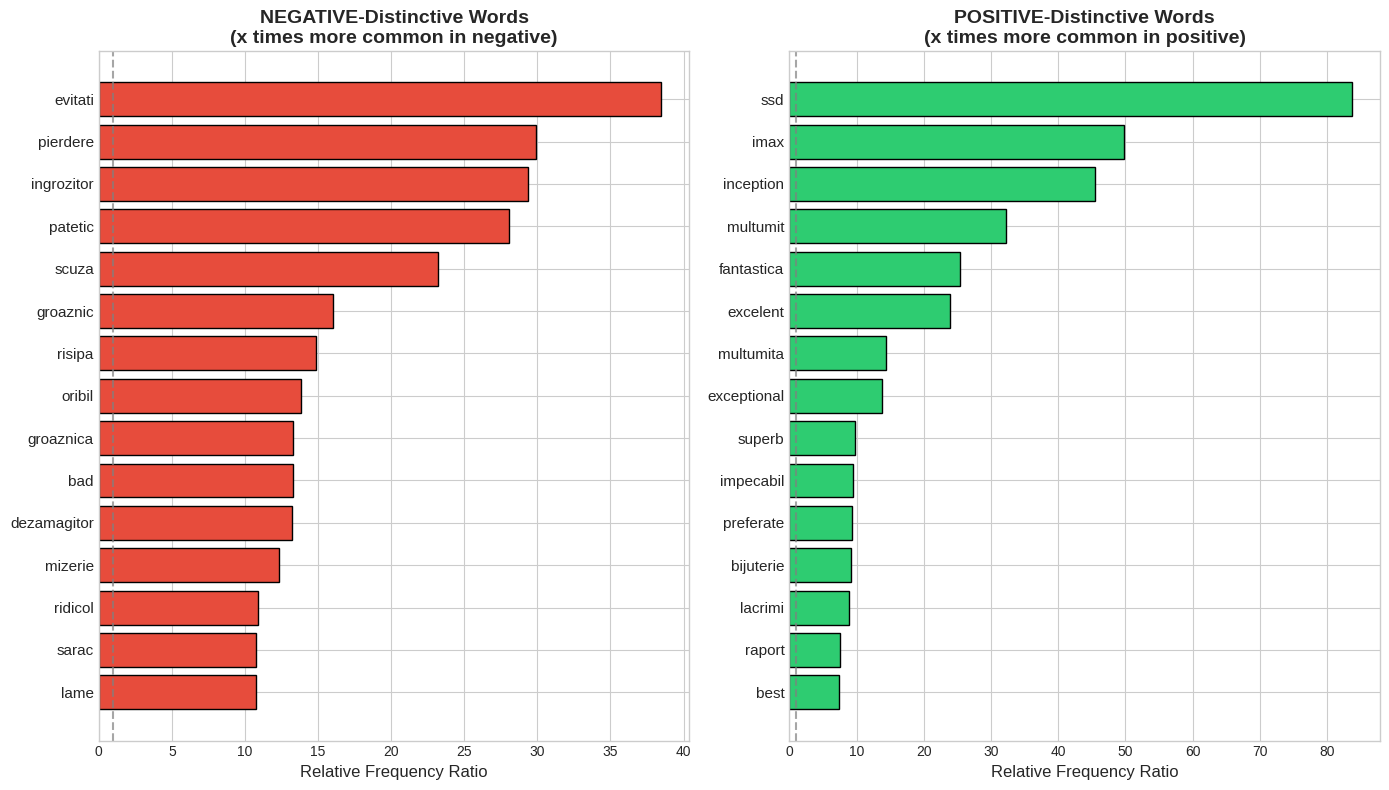


✓ Plot saved to ../plots/eda/distinctive_words.png


In [22]:
# Visualize distinctive words
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Negative-distinctive
ax = axes[0]
words, ratios = zip(*neg_distinctive[:15])
y_pos = range(len(words))
ax.barh(y_pos, ratios, color='#e74c3c', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(words, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Relative Frequency Ratio', fontsize=12)
ax.set_title('NEGATIVE-Distinctive Words\n(x times more common in negative)', fontsize=14, fontweight='bold')
ax.axvline(1, color='gray', linestyle='--', alpha=0.7)

# Positive-distinctive
ax = axes[1]
words, ratios = zip(*pos_distinctive[:15])
y_pos = range(len(words))
ax.barh(y_pos, ratios, color='#2ecc71', edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels(words, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Relative Frequency Ratio', fontsize=12)
ax.set_title('POSITIVE-Distinctive Words\n(x times more common in positive)', fontsize=14, fontweight='bold')
ax.axvline(1, color='gray', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'distinctive_words.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Plot saved to {PLOTS_DIR / 'distinctive_words.png'}")

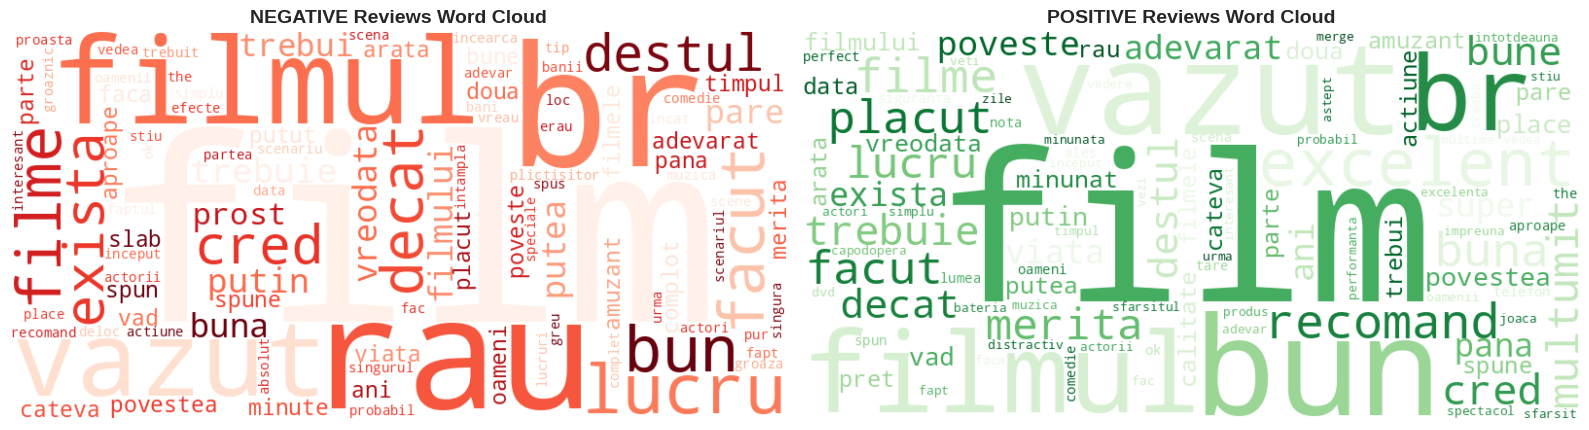


✓ Plot saved to ../plots/eda/wordclouds.png


In [23]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Negative wordcloud
wc_neg = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Reds',
    max_words=100,
).generate_from_frequencies(neg_freq_filtered)
axes[0].imshow(wc_neg, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('NEGATIVE Reviews Word Cloud', fontsize=14, fontweight='bold')
    
# Positive wordcloud
wc_pos = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='Greens',
    max_words=100,
).generate_from_frequencies(pos_freq_filtered)
axes[1].imshow(wc_pos, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('POSITIVE Reviews Word Cloud', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'wordclouds.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Plot saved to {PLOTS_DIR / 'wordclouds.png'}")

## 5. Summary Statistics

In [24]:
# Final summary
print("="*60)
print("DATA EXPLORATION SUMMARY")
print("="*60)

print("\n📊 DATASET SIZE:")
print(f"   Train: {len(train_df):,} samples")
print(f"   Validation: {len(val_df):,} samples")
print(f"   Test: {len(test_df):,} samples")

print("\n⚖️ CLASS BALANCE (Train):")
neg_pct = (train_df['label'] == 0).mean() * 100
pos_pct = (train_df['label'] == 1).mean() * 100
print(f"   Negative: {neg_pct:.1f}%")
print(f"   Positive: {pos_pct:.1f}%")
print(f"   Balance: {'Balanced ✓' if 40 <= neg_pct <= 60 else 'Imbalanced ⚠️'}")

print("\n📏 TEXT LENGTH (Train):")
print(f"   Mean word count: {train_df['word_count'].mean():.1f}")
print(f"   Median word count: {train_df['word_count'].median():.1f}")
print(f"   95th percentile: {np.percentile(train_df['word_count'], 95):.0f} words")
print(f"   Max word count: {train_df['word_count'].max()} words")

print("\n📝 VOCABULARY:")
all_words = neg_freq + pos_freq
print(f"   Total unique words: {len(all_words):,}")
print(f"   Words appearing 2+ times: {sum(1 for w, c in all_words.items() if c >= 2):,}")

print("\n💾 SAVED PLOTS:")
for plot_file in sorted(PLOTS_DIR.glob('*.png')):
    print(f"   ✓ {plot_file.name}")

print("\n" + "="*60)

DATA EXPLORATION SUMMARY

📊 DATASET SIZE:
   Train: 15,003 samples
   Validation: 2,648 samples
   Test: 11,005 samples

⚖️ CLASS BALANCE (Train):
   Negative: 38.7%
   Positive: 61.3%
   Balance: Imbalanced ⚠️

📏 TEXT LENGTH (Train):
   Mean word count: 77.7
   Median word count: 79.0
   95th percentile: 148 words
   Max word count: 373 words

📝 VOCABULARY:
   Total unique words: 47,548
   Words appearing 2+ times: 25,796

💾 SAVED PLOTS:
   ✓ char_count_distribution.png
   ✓ class_balance.png
   ✓ class_balance_pie.png
   ✓ distinctive_words.png
   ✓ top_words_by_class.png
   ✓ top_words_filtered.png
   ✓ word_count_distribution.png
   ✓ wordclouds.png



In [25]:
# Save summary as JSON
import json

summary = {
    'dataset_size': {
        'train': len(train_df),
        'val': len(val_df),
        'test': len(test_df),
    },
    'class_balance_train': {
        'negative_pct': round(neg_pct, 2),
        'positive_pct': round(pos_pct, 2),
    },
    'text_length_train': {
        'mean_words': round(train_df['word_count'].mean(), 2),
        'median_words': round(train_df['word_count'].median(), 2),
        'p95_words': int(np.percentile(train_df['word_count'], 95)),
        'max_words': int(train_df['word_count'].max()),
        'mean_chars': round(train_df['char_count'].mean(), 2),
    },
    'vocabulary': {
        'total_unique_words': len(all_words),
        'words_freq_2plus': sum(1 for w, c in all_words.items() if c >= 2),
    },
    'recommendations': {
        'max_seq_len': int(np.ceil(np.percentile(train_df['word_count'], 95) / 32) * 32),
    }
}

with open(PLOTS_DIR / 'eda_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Summary saved to {PLOTS_DIR / 'eda_summary.json'}")

✓ Summary saved to ../plots/eda/eda_summary.json
